In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
TARGET_FEATURE_NAME = "label"
TARGET_FEATURE_LABELS = ["0", "1"]
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

# Numeric Feature
NUMERIC_FEATURE_NAMES = [
    'movieAvgRating',
    'movieRatingStddev',
    'movieRatingCount',
    'userAvgRating',
    'userRatingStddev',
    'userRatingCount',
    'releaseYear',
]

# ID Feature
ID_FEATURE_NAMES = ['movieId', 
                    'userId', 
                    'userRatedMovie1',
                    'userRatedMovie2',
                    'userRatedMovie3',
                    'userRatedMovie4',
                    'userRatedMovie5',]

# Categorical Feature
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 
               'Horror', 'Romance', 'War', 
               'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 
               'IMAX', 'Mystery', 'Children', 'Musical']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,
    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES + ID_FEATURE_NAMES

# 读取CSV时的缺失值填充
COLUMN_DEFAULTS = [
    0.0 if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else "NA"
    for feature_name in FEATURE_NAMES
]

In [3]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        if feature_name in ID_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [4]:
def encode_DIN_inputs(inputs, embedding_dims=10):

    movie_hash_layer = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=1000)
    movie_emb_layer = tf.keras.layers.Embedding(input_dim=1000, 
                                                output_dim=embedding_dims, 
                                                mask_zero=True)
    candidate_movie = tf.expand_dims(inputs['movieId'], 1)
    candidate = movie_emb_layer(movie_hash_layer(candidate_movie))
    
    user_behaviors = [
        inputs['userRatedMovie1'],
        inputs['userRatedMovie2'],
        inputs['userRatedMovie3'],
        inputs['userRatedMovie4'],
        inputs['userRatedMovie5']
    ]
    user_behaviors = tf.reshape(user_behaviors, (-1, 5))
    user_behaviors = movie_emb_layer(movie_hash_layer(user_behaviors))
    
    # user id embedding feature
    user_col = tf.feature_column.categorical_column_with_hash_bucket(key='userId', hash_bucket_size=1000)
    user_emb_col = tf.feature_column.embedding_column(user_col, embedding_dims)

    # user genre embedding feature
    user_genre_col = tf.feature_column.categorical_column_with_vocabulary_list(key="userGenre1", vocabulary_list=genre_vocab)
    user_genre_emb_col = tf.feature_column.embedding_column(user_genre_col, embedding_dims)

    user_profile = [
        user_emb_col,
        user_genre_emb_col,
        tf.feature_column.numeric_column('userRatingCount'),
        tf.feature_column.numeric_column('userAvgRating'),
        tf.feature_column.numeric_column('userRatingStddev'),
    ]
    
    # item genre embedding feature
    item_genre_col = tf.feature_column.categorical_column_with_vocabulary_list(key="movieGenre1", vocabulary_list=genre_vocab)
    item_genre_emb_col = tf.feature_column.embedding_column(item_genre_col, embedding_dims)

    context = [
        item_genre_emb_col,
        tf.feature_column.numeric_column('releaseYear'),
        tf.feature_column.numeric_column('movieRatingCount'),
        tf.feature_column.numeric_column('movieAvgRating'),
        tf.feature_column.numeric_column('movieRatingStddev'),
    ]
        
    return user_behaviors, candidate, user_profile, context

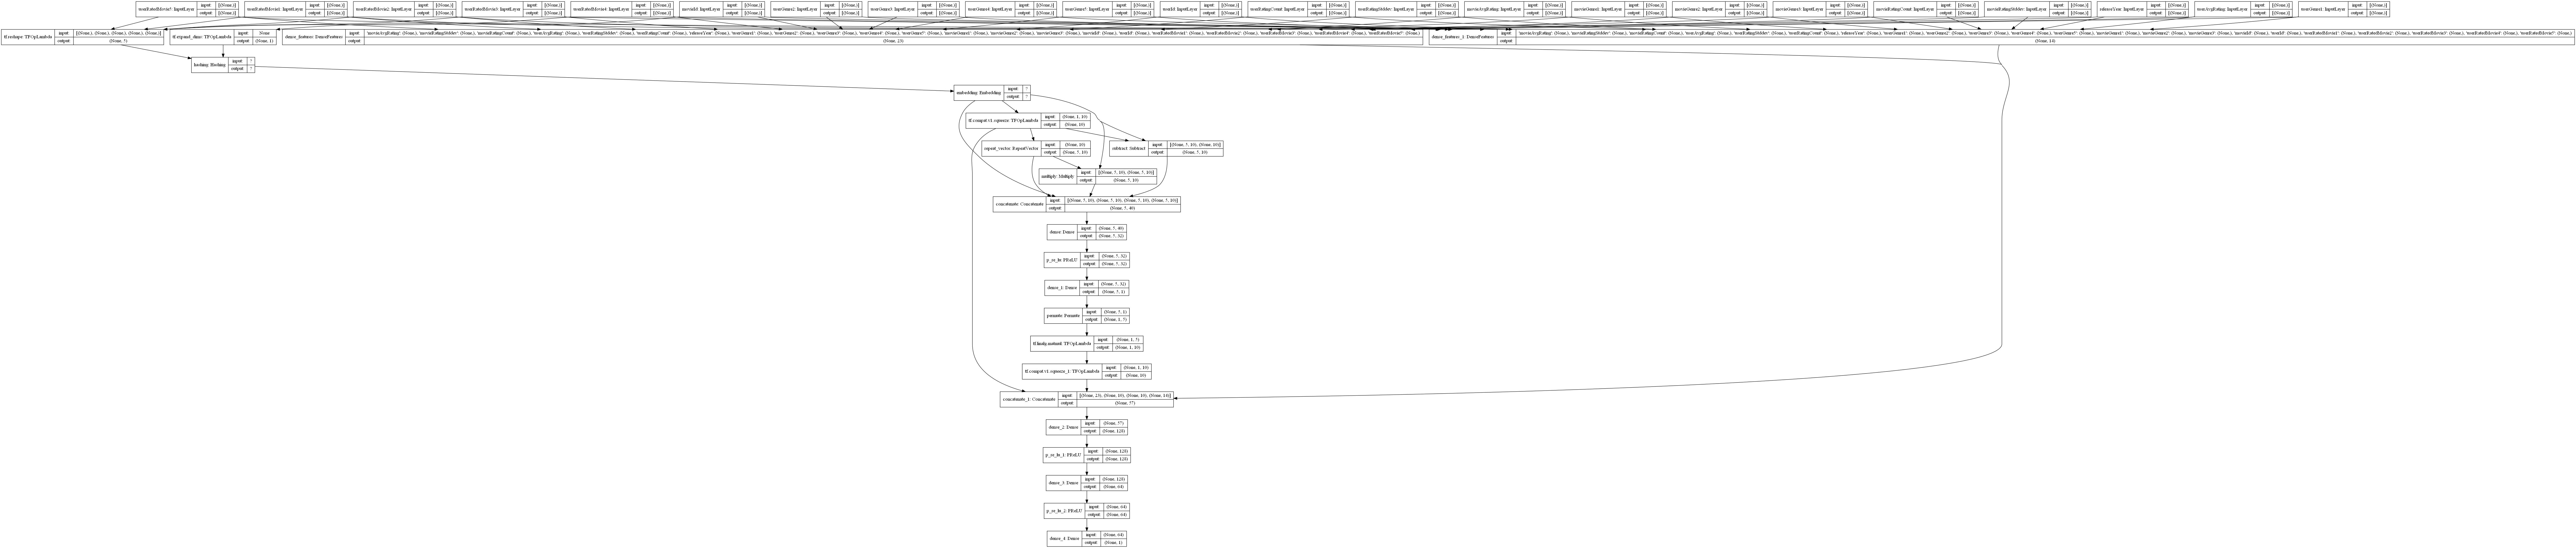

In [5]:
def create_DIN_model():
    embedding_dims = 10
    num_of_behaviors = 5
    inputs = create_model_inputs()
    user_behaviors, candidate, user_profile, context = encode_DIN_inputs(inputs=inputs, 
                                                                         embedding_dims=embedding_dims)

    candidate_features = candidate
    user_behaviors_features = user_behaviors
#     user_behaviors_features = tf.keras.layers.DenseFeatures(user_behaviors)(inputs)
#     candidate_features = tf.keras.layers.DenseFeatures(candidate)(inputs)
    user_profile_features = tf.keras.layers.DenseFeatures(user_profile)(inputs)
    context_features = tf.keras.layers.DenseFeatures(context)(inputs)

    candidate_features = tf.squeeze(candidate_features, axis=1) # shape (None, 10)
    repeated_candidate_features = tf.keras.layers.RepeatVector(num_of_behaviors)(candidate_features) # shape (None, 5, 10)

    
    activation_sub= tf.keras.layers.Subtract()([user_behaviors_features, candidate_features]) # element-wise sub
    activation_product = tf.keras.layers.Multiply()([user_behaviors_features, repeated_candidate_features]) # element-wise product
    activation_all = tf.keras.layers.concatenate([activation_sub, user_behaviors_features,
                                                  repeated_candidate_features, activation_product], axis=-1) # shape (None, 5, 40)
    
    activation_unit = tf.keras.layers.Dense(32)(activation_all)
    activation_unit = tf.keras.layers.PReLU()(activation_unit)
    activation_unit = tf.keras.layers.Dense(1, activation='sigmoid')(activation_unit) # shape (None, 5, 1)
    activation_unit = tf.keras.layers.Permute((2, 1))(activation_unit) # shape (None, 1, 5)
    user_behaviors_pooled = tf.matmul(activation_unit, user_behaviors_features) # shape (None, 1, 10)
    user_behaviors_pooled = tf.squeeze(user_behaviors_pooled, axis=1)

    # fc layer
    concat_features = tf.keras.layers.concatenate([user_profile_features, 
                                                   user_behaviors_pooled, 
                                                   candidate_features, 
                                                   context_features])
    
    outputs = tf.keras.layers.Dense(128)(concat_features)
    outputs = tf.keras.layers.PReLU()(outputs)
    outputs = tf.keras.layers.Dense(64)(outputs)
    outputs = tf.keras.layers.PReLU()(outputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs)

    model = tf.keras.Model(inputs, outputs)
    return model
    
DIN_model = create_DIN_model()
keras.utils.plot_model(DIN_model, show_shapes=True, rankdir="TB")

In [6]:
training_samples_file_path = './sampledata/trainingSamples.csv'
test_samples_file_path = './sampledata/testSamples.csv'

def get_dataset(file_path, batch_size):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=batch_size,
        label_name='label',
        na_value="0",
        num_epochs=1,
        ignore_errors=True)
    return dataset.cache()

batch_size = 128
# split as test dataset and training dataset
train_dataset = get_dataset(training_samples_file_path, batch_size)
test_dataset = get_dataset(test_samples_file_path, batch_size)

In [7]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 12
num_epochs = 10

def run_experiment(model): 

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')],
    )
    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy, _, _ = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [8]:
run_experiment(DIN_model)

Start training the model...
Epoch 1/10


D:\Conda\envs\studio\lib\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['rating', 'timestamp', 'userAvgReleaseYear', 'userReleaseYearStddev'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


694/694 [==============================] - 5s 4ms/step - loss: 9.7607 - accuracy: 0.5397 - auc: 0.5441 - auc_1: 0.5990
Epoch 2/10
694/694 [==============================] - 2s 3ms/step - loss: 3.0344 - accuracy: 0.5820 - auc: 0.6015 - auc_1: 0.6451
Epoch 3/10
694/694 [==============================] - 2s 3ms/step - loss: 2.5872 - accuracy: 0.5892 - auc: 0.6114 - auc_1: 0.6540
Epoch 4/10
694/694 [==============================] - 2s 3ms/step - loss: 2.0183 - accuracy: 0.6014 - auc: 0.6276 - auc_1: 0.6702
Epoch 5/10
694/694 [==============================] - 2s 3ms/step - loss: 1.9349 - accuracy: 0.6007 - auc: 0.6274 - auc_1: 0.6715
Epoch 6/10
694/694 [==============================] - 2s 3ms/step - loss: 2.1173 - accuracy: 0.5956 - auc: 0.6176 - auc_1: 0.6606
Epoch 7/10
694/694 [==============================] - 2s 4ms/step - loss: 1.2263 - accuracy: 0.6218 - auc: 0.6585 - auc_1: 0.6999
Epoch 8/10
694/694 [==============================] - 2s 3ms/step - loss: 1.4779 - accuracy: 0.6133 -